Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [22]:
NAME = "LARA DULAR"
COLLABORATORS = ""

---

# Vaja 6: Geometrijska kalibracija kamere

## Navodila
S postopkom **geometrijske kalibracije** slikovnega sistema zagotovimo enakomerno absolutno velikost slikovnega elementa, ki je sicer v splošnem lahko odvisna od položaja v sliki (npr. zaradi vpliva projekcije) in dodatno popačena zaradi optičnih aberacij, med katerimi so najpogostejše radialne distorzije tipa sodček in blazinica. Po geometrijski kalibraciji slikovnega sistema in preslikavi slike v metrični prostor lahko izvajamo meritve dimenzij, ploščin in volumnov objektov na slikah v absolutnih metričnih enotah (npr. mm, mm$^2$, mm$^3$). Za geometrijsko kalibracijo 2D slikovnih sistemov **uporabljamo ravninske kalibre** z enostavnimi, a dobro definiranimi vzorci, kot so **šahovnica, mreža tankih črt ali diskretno polje točk**. Geometrijska kalibracija vključuje poravnavo vzorcev zajete $f(u,v)$ in referenčne $g(x,y)$ slike kalibracijskega objekta. Uporabimo lahko celotno slikovno informacijo ali pa izluščimo korespondenčne pare točk referenčne in kalibracijske slike ter z njimi določimo parametre preslikave oz. poravnavo tako, da se preslikane točke referenčne slike čim bolje prekrivajo s korespondenčnimi točkami kalibracijske slike in obratno. 

![Ravninski kalibri, poravnava korespondenčnih točk](images/RV_7_SLO_Kalibracija.png)

V praksi se za geometrijsko kalibracijo slikovnih sistemov običajno uporablja **projektivna geometrijska preslikava**, ki je za preslikavo med dvema ravninama določena z 8 parametri ($a_{11}$, $a_{12}$, $a_{21}$, $a_{22}$, $t_x$, $t_y$, $p_x$, $p_y$) in ki jo zapišemo z nehomogeno $3 \times 3$ matriko, za odpravo popačenj tipa sodček in blazinica pa **Brownov model radialnih distorzij**, ki je določen s centrom $(u_c,v_c)$ in utežmi radialnih funkcij $K_i$. Geometrijsko kalibracijo izvedemo tako, da točke v metričnem prostoru s projektivno preslikavo preslikamo v prostor slike in jih nato še popačimo z modelom radialnih distorzij. Ker je Brownov model radialnih distorzij nelinearen, je za določanje parametrov modela radialnih distorzij potrebno uporabiti optimizacijski postopek, ki minimizira kriterijsko funkcijo, npr. srednjo kvadratno Evklidsko razdaljo $E^2 = \sum_{k=1}^N \| \mathcal{T}_{radialna}\left(\mathcal{T}_{projektivna}(x_k,y_k)\right) - (u_k,v_k) \|^2$ med korespondenčnimi točkami na kalibru. 

![Preslikave](images/RV_7_SLO_Preslikave.png)

Za določanje optimalnih parametrov modela radialnih distorij in 2D projektivne preslikave boste uporabili postopek **Nelder-Mead simpleksne optimizacije**. S simpleksno optimizacijo lahko poiščemo lokalni optimum poljubne funkcije več spremenljivk. Simpleks predstavlja geometrijsko strukturo, s pomočjo katere vzorčimo parametrični prostor in je za funkcije dveh spremenljivk $f(x,y)$ predstavljen s tremi oglišči oz. s trikotnikom. S simpleksno optimizacijo poljubno funkcijo minimiziramo tako, da oglišča z največjo vrednostjo $f(x,y)$ nadomestimo z novimi oglišči. Nova oglišča lahko določimo na štiri načine: 
1) zrcaljenje, 
2) širjenje, 
3) krčenje in 
4) mnogokratno krčenje. 
Ko oglišča nadomestimo dobimo nov simpleks in poiščemo pripadajoče vrednosti $f(x,y)$ v novih ogliščih. Postopek ponavljamo in ga ustavimo, dokler velikost simpleksa ne pade pod neko minimalno vrednost, položaj lokalnega optimuma pa predstavlja oglišče z optimalno vrednostjo $f(x,y)$.

![Optimizacija](images/RV_7_SLO_Optimizacija.png)	  

Pri vaji boste napisali funkcije za popravek radialnih distorzij in 2D projektivno preslikavo. Z določanjem oglišč na sliki kalibracijskega objekta `data/calibration-object.jpg` in njihovo preslikavo v metrični prostor s poravnavo korespondenčnih oglišč boste izvedli geometrijsko kalibracijo slikovnega sistema. Nato boste sliko kljunastega merila `data/test-object.jpg`, ki je bila zajeta z istim slikovnim sistemom kot slika kalibra, preslikali v metrični prostor in preverili ali je geometrijska kalibracija pravilna.

## Naloge
1. Napišite funkcijo, ki preslika vhodne nepopačene koordinate $(u,v)$ v spremenljivkah `iCoorU` in `iCoorV` z Brownovim modelom radialnih distorzij poljubnega reda $n$: 
```python
    def transRadial( iK, iUc, iVc, iCoorU, iCoorV ):
        return oCoorUd, oCoorVd
```
kjer je `iK` vrstični vektor $1\times n$ parametrov radialnih distorzij, `iUc` in `iVc` pa prestavljata $(u_c,v_c)$ koordinati centra radialnih distorzij. Funkcija vrne preslikane *popačene* koordinate točk v spremenljivkah `iCoorUd` in `iCoorVd`. 

 S pomočjo funkcije `numpy.meshgrid()` ustvarite diskretno mrežo koordinatnih točk in jih preslikajte s poljubnim Brownovim modelom radialnih distorzij prvega reda ($n = 1$) ter narišite vhodne $(u,v)$ in preslikane točke $(u_d,v_d)$. Preverite vpliv položaja centra radialnih distorzij na preslikavo koordinatnih točk. Katere vrednosti `iK` predstavljajo distorzije tipa sodček in katere tipa blazinica? Pri katerih vrednostih parametrov bo ta preslikava identiteta?

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as im
from scipy.interpolate import interpn

# Nalozi sliko
def loadImage(iPath):
    oImage = np.array(im.open(iPath))
    return oImage

# Prikazi sliko
def showImage(iImage, iTitle=''):
    plt.figure()
    plt.imshow(iImage, cmap = 'gray')
    plt.suptitle(iTitle)
    plt.xlabel('x')
    plt.ylabel('y')
    
# Pretvori v sivinsko sliko
def colorToGray(iImage):
    dtype = iImage.dtype
    r = iImage[:,:,0].astype('float')
    g = iImage[:,:,1].astype('float')
    b = iImage[:,:,2].astype('float')
    
    return (r*0.299 + g*0.587 + b*0.114).astype(dtype)

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def mapAffineApprox2D(iPtsRef, iPtsMov):
    """Afina aproksimacijska poravnava"""
    iPtsRef = np.matrix(iPtsRef) 
    iPtsMov = np.matrix(iPtsMov) 
    # po potrebi dodaj homogeno koordinato
    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)
    # afina aproksimacija (s psevdoinverzom)
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()            
    # psevdoinverz
    #oMat2D = np.dot(iPtsRef, np.linalg.pinv(iPtsMov))        
    # psevdoinverz na dolgo in siroko:
    oMat2D = iPtsRef * iPtsMov.transpose() * \
    np.linalg.inv( iPtsMov * iPtsMov.transpose() )
    return oMat2D

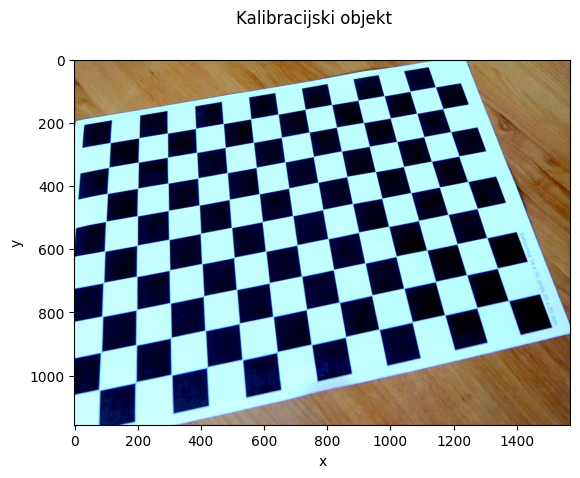

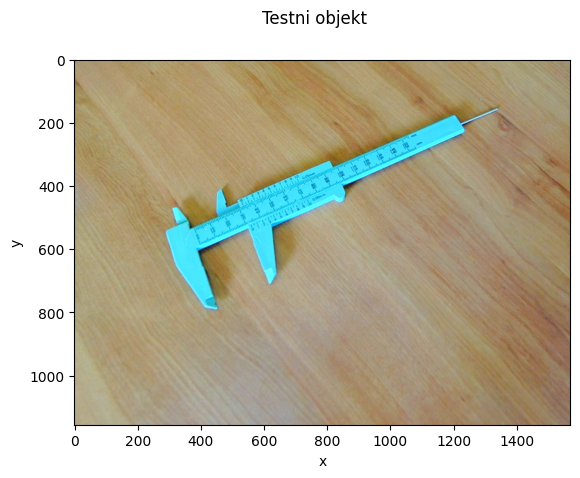

In [24]:
# Nalozimo in prikazemo slike
iCalImage = loadImage('data/calibration-object.jpg')
iTestImage = loadImage('data/test-object.jpg')

showImage( iCalImage, 'Kalibracijski objekt' )
showImage( iTestImage, 'Testni objekt' )

In [25]:
def transRadial( iK, iUc, iVc, iCoorU, iCoorV ):
    """Funkcija za preslikavo z Brownovim modelom distorzij"""    
    # Preveri vhodne podatke
    iK = np.array(iK)
    iCoorU = np.array(iCoorU)
    iCoorV = np.array(iCoorV)
    if np.size(iCoorU) != np.size(iCoorV):
        print("Stevio U n V koordinat razlicno!")
    # odstej koordinate cenra
    oCoorUd = iCoorU - iUc; oCoorVd = iCoorV - iVc
    # pripravi izhone koordinate
    sUd = np.max(np.abs(oCoorUd))
    sVd = np.max(np.abs(oCoorVd))
    
    oCoorUd = oCoorUd / sUd
    oCoorVd = oCoorVd / sVd
    
    # preracunaj radialna popacenja
    R2 = oCoorUd**2.0 + oCoorVd **2.0
    iK = iK.flatten()
    oCoorRd = np.ones_like(oCoorUd)
    
    for i in range(iK.size):
        oCoorRd = oCoorRd + iK[i]*(R2**(i+1))
    # izracunaj izhodne koorniate
    oCoorUd = oCoorUd * oCoorRd * sUd + iUc
    oCoorVd = oCoorVd * oCoorRd * sVd + iVc
    # END SOLUTION
    return oCoorUd, oCoorVd

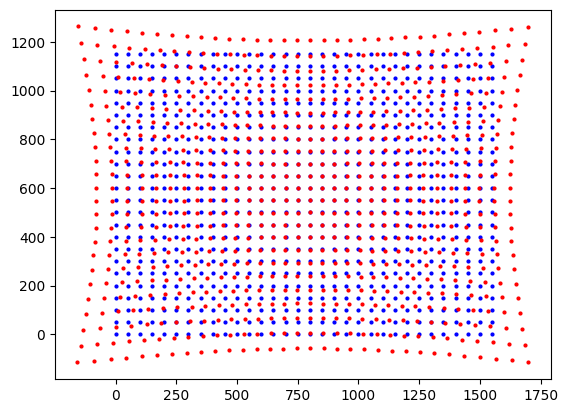

In [26]:
# ustvari mrezo tock
iCoorU, iCoorV = np.meshgrid(range(iCalImage.shape[1]), 
                             range(iCalImage.shape[0]),\
                             sparse=False, indexing='xy')
# preslikaj tocke (iK = -1e-1 in +1e-1, sodcek in blazinica)
oCoorUd, oCoorVd = transRadial([1e-1], iCalImage.shape[1]/2,  # prvi parameter -1e-1 za sodček
                               iCalImage.shape[0]/2,
                               iCoorU, iCoorV)

# prikazi originalne in preslikane tocke
s = 50
plt.plot(iCoorU[::s,::s].flatten(),iCoorV[::s,::s].flatten(),
         'ob',markersize=2.0)
plt.plot(oCoorUd[::s,::s].flatten(),oCoorVd[::s,::s].flatten(),
         'or',markersize=2.0)

2. Napišite funkcijo, ki vhodne koordinate $(x,y)$ v spremenljivkah `iCoorX` in `iCoorY` preslika s poljubno 2D projektivno preslikavo:
```python
    def transProjective2D( iPar, iCoorX, iCoorY ):
        return oCoorU, oCoorV
```    
kjer je `iPar` vrstični $1\times 8$ vektor s parametri ($a_{11}$, $a_{12}$, $t_x$, $a_{21}$, $a_{22}$, $t_y$, $p_x$, $p_y$). Funkcija vrne preslikane koordinate točk v spremenljivkah `oCoorU` in `oCoorV`.

 Preverite delovanje funkcije tako, da vzorčne točke slike `data/test-object.jpg` preslikate s poljubnimi parametri projektivne preslikave in s funkcijo za interpolacijo prvega reda `scipy.interpolate.interpn()` v preslikanih točkah poiščete nove sivinske vrednosti. Prikažite preslikano sliko.

In [27]:
def transProjective2D( iPar, iCoorX, iCoorY ):
    """Funkcija za projektivno preslikavo"""
    iPar = np.asarray(iPar)
    iCoorX = np.asarray(iCoorX)
    iCoorY = np.asarray(iCoorY)
    if np.size(iCoorY) != np.size(iCoorX):
        print("Stevio X in Y koordinat razlicno!")
        
    # izvedi projektivno rpeslikava
    # iPar = [a11, a12, tx, a21, a22, ty, px, py]
    oDenom = iPar[6] * iCoorX + iPar[7] * iCoorY + 1
    oCoorU = iPar[0] * iCoorX + iPar[1] * iCoorY + iPar[2]
    oCoorV = iPar[3] * iCoorX + iPar[4] * iCoorY + iPar[5]
    
    # vrni preslikane tocke
    return oCoorU/oDenom, oCoorV/oDenom

Preizkusite funkcijo `transProjective2D`:

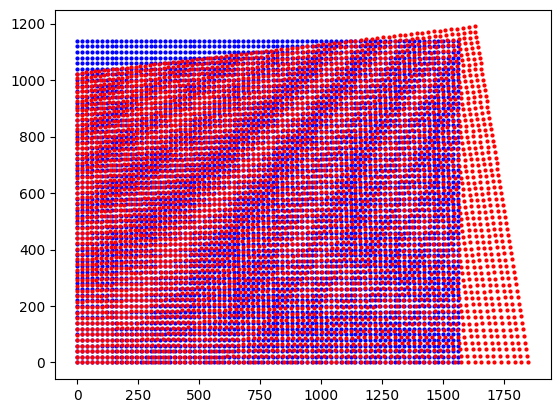

In [28]:
# ustvari mrezo tock
iCoorX, iCoorY = np.meshgrid(range(iCalImage.shape[1]), 
                             range(iCalImage.shape[0]),
                             sparse=False, indexing='xy')
# preslikaj tocke
#iPar = [a11 a12 tx a21 a22 ty px py]
iPar = [1, 0, 0, 0, 1, 0, -1e-4, 1e-4];
oCoorU, oCoorV = transProjective2D( iPar, iCoorX, iCoorY )
# prikazi originalne in preslikane tocke
s = 20
plt.plot(iCoorX[::s,::s].flatten(),iCoorY[::s,::s].flatten(),'ob',markersize=2.0)
plt.plot(oCoorU[::s,::s].flatten(),oCoorV[::s,::s].flatten(),'or',markersize=2.0)
# izvedi interpolacijo prvega reda
iCalImageG = colorToGray( iCalImage )

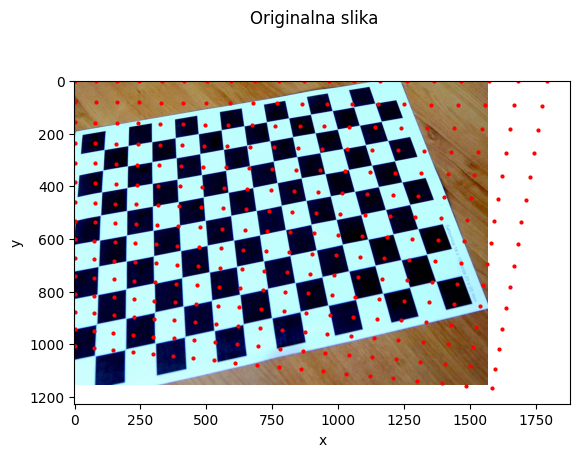

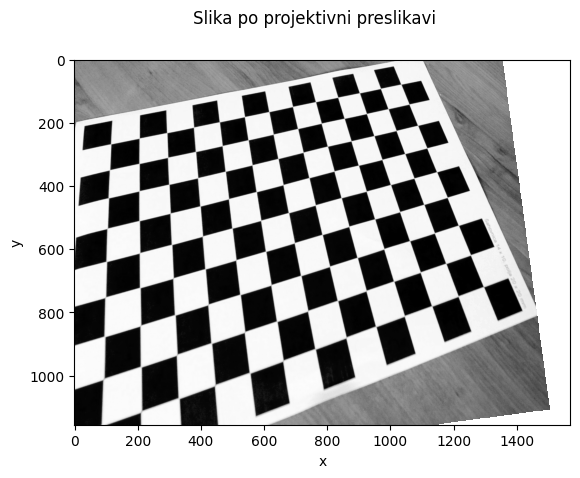

In [29]:
s = 1
dy, dx = iCalImageG.shape
oInterpImageG = interpn((np.arange(dy), np.arange(dx)), 
                        iCalImageG, 
                        (oCoorV[::s,::s], oCoorU[::s,::s]), 
                        method = "linear", bounds_error=False)
  
showImage( iCalImage, 'Originalna slika' )
s = 80
plt.plot(oCoorU[::s,::s].flatten(), oCoorV[::s,::s].flatten(),
         'or', markersize=2.0)    

showImage( oInterpImageG, 'Slika po projektivni preslikavi' )

3. Preizkusite delovanje simpleksne optimizacije s pomočjo Pythonove funkcije `scipy.optimize.fmin()` tako, da poiščete minimum funkcije $f(x,y) = 100 (y - x^2)^2 + (1-x)^2$, pri tem pa uporabite začetni približek $x_0 = (1.2, 1)$. Z nastavljanjem dodatnih parametrov v klicu funkcije `fmin(func, x0, ...)` nastavite prikaz informacij o iteracijah (`fmin(..., disp = 1, callback = fname)`, kjer je `fname(X)` funkcija za oblikovanje izpisa), maksimalno število iteracij (`fmin(..., maxiter = 100)`), najmanjšo napako funkcije (`fmin(..., ftol = 1e-6)`) in najmanjši korak (`fmin(..., xtol = 1e-6)`). Preverite, da je minimum $f(x,y)$ v točki ($1, 1$) in opazujte zaporedje operacij simpleksa.		

Iter    x            y            f(X)     
   1   -4.500000    5.375000    22156.812500
   2   -4.250000    5.937500    14729.125000
   3   -3.125000    6.468750    1103.954102
   4   -2.875000    7.031250    167.383789
   5   -2.875000    7.031250    167.383789
   6   -2.875000    7.031250    167.383789
   7   -2.875000    7.031250    167.383789
   8   -2.625000    7.031250    15.118164
   9   -2.625000    7.031250    15.118164
  10   -2.625000    7.031250    15.118164
  11   -2.687500    7.125000    14.551331
  12   -2.687500    7.125000    14.551331
  13   -2.664062    7.027344    13.913749
  14   -2.650391    7.053711    13.410268
  15   -2.650391    7.053711    13.410268
  16   -2.651367    7.016113    13.351073
  17   -2.638916    6.995483    13.341602
  18   -2.639893    6.957886    13.261244
  19   -2.639893    6.957886    13.261244
  20   -2.628418    6.899658    13.173379
  21   -2.628418    6.899658    13.173379
  22   -2.609039    6.833237    13.093550
  23   -2.594589    

C:\Users\gj1182\AppData\Local\Temp\ipykernel_5640\3628287514.py:28: RuntimeWarning: Maximum number of iterations has been exceeded.
  xopt = fmin(func = F, x0 = np.array([-5,5]), disp =1, xtol=1e-6, ftol=1e-6, maxiter=100, callback = callbackF)


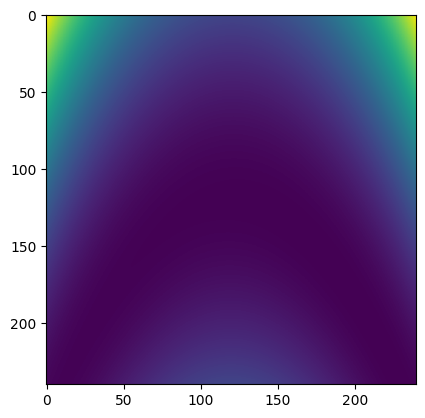

In [30]:
# Nasa funkcija
def F( arg ):
    x = arg[0]
    y = arg[1]
    return 100*(y-x**2)**2+(1-x)**2

Nfeval = 1

# izpisovanje vredonsti
def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'
          .format(Nfeval, Xi[0], Xi[1], F(Xi)))
    Nfeval += 1

# test funkcije
iCoorX, iCoorY = np.meshgrid(np.arange(-1.2,1.2,0.01), 
                             np.arange(-1.2,1.2,0.01),
                             sparse=False, indexing='xy')
plt.figure()
plt.imshow(F((iCoorX, iCoorY)))

# uvozi funkcijo za simpleksno optimizacijo
from scipy.optimize import fmin    
# poisci minimalno vrednost funkcije z fmin
Nfeval = 1
print('{0:4s}    {1:9s}    {2:9s}    {3:9s}'.format('Iter', 'x', 'y', 'f(X)'))
xopt = fmin(func = F, x0 = np.array([-5,5]), disp =1, xtol=1e-6, ftol=1e-6, maxiter=100, callback = callbackF)
print(xopt)

4. Napišite funkcijo za izračun srednje kvadratne Evklidske razdalje med točkami $(u_k,v_k)$ v zajeti sliki, ki so preslikane z modelom radialnih distorzij, in korespondenčnimi točkami $(x_k,y_k)$ v metričnem prostoru, ki so preslikane s projektivno preslikavo:
$$
	E^2 = \frac{1}{N}\sum_{k=1}^N \| \mathcal{T}_{radialna}\left(\mathcal{T}_{projektivna}(x_k,y_k)\right) - (u_k,v_k) \|^2 \,.
$$
Funkcija naj kot prvi parameter vzame vrstični vektor `iPar`, ki predstavlja parametre 2D projektivne preslikave in modela radialnih distorzij kot ($a_{11}$, $a_{12}$, $t_x$, $a_{21}$, $a_{22}$, $t_y$, $p_x$, $p_y$, $u_c$, $u_v$, $K_1$, $K_2$, $\ldots$, $K_n$). Ostali parametri funkcije naj bodo $N$ koordinat točk $(u_k,v_k)\,\rightarrow$ `iCoorU`, `iCoorV`, in $N$ koordinat točk $(x_k,y_k)\,\rightarrow$ `iCoorX`, `iCoorY`:
```python
    def geomCalibErr( iPar, iCoorU, iCoorV, iCoorX, iCoorY ):
        return oErr2
```
Funkcija naj izračuna napako med preslikanimi točkami $E^2$, ki jo vrne kot skalarno spremenljivko `oErr2`. Začetni približek parametrov ($a_{11}$, $a_{12}$, $t_x$, $a_{21}$, $a_{22}$, $t_y$) določite s pomočjo funkcije za afino aproksimacijsko preslikavo `mapAffineApprox2D()` (Vaja 5). 

 Preizkusite delovanje funkcije tako, da naložite sliko `data/calibration-object.jpg` in ročno označite vsaj 8 oglišč na kalibracijskem objektu s pomočjo funkcije `fig.canvas.mpl_connect()`. Za potrebe geometrijske kalibracije ustvarite referenčno mrežo točk, ki sovpada s položajem ogljišč na idealni, ravninski sliki šahovnice. Referenčne točke naj ležijo v metričnem prostoru, pri tem pa predpostavite, da ima stranica kvadratnega polja šahovnice dolžino 20 mm. Naprimer, oglišče v levem zgornjem kotu šahovnice naj ima koordinati ($20, 20$). Z uporabo simpleksne optimizacije določite optimalne parametre `iPar` tako, da bo napaka $E^2$  minimalna. Prikažite referenčne točke in točke oglišč na sliki pred in po preslikavi. 

In [31]:
# Implementacija funkcije geomCalibTrans
def geomCalibTrans( iPar, iCoorX, iCoorY ):
    """Funkcija za preslikavo tock (projektivna+radialne distorzije)"""
    iParProj = iPar[0:8]
    iParRad = iPar[8:]
    #preslikava v prostor slike
    iCoorUt, iCoorVt = transProjective2D(iParProj, iCoorX, iCoorY)
    # korekcija radialnih distorzij
    iCoorUt, iCoorVt = transRadial(iParRad[2:], iParRad[0], iParRad[1], iCoorUt, iCoorVt)
    # vrni preslikane tocke
    return iCoorUt, iCoorVt

# Implementirajte funkcijo geomCalibErr
def geomCalibErr( iPar, iCoorU, iCoorV, iCoorX, iCoorY):
    """Funkcija za izracun kalibracijske napake"""
    iCoorUt, iCoorVt = geomCalibTrans( iPar, iCoorX, iCoorY)
    #izracun napake poravnave
    oErr2 = np.mean((iCoorU-iCoorUt)**2 + (iCoorV-iCoorVt)**2)
    # vrni vrednost napake
    return oErr2

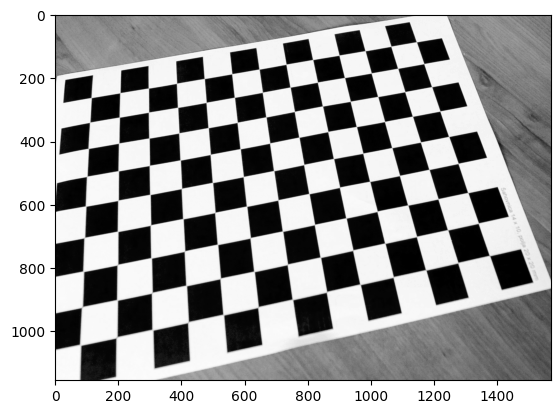

In [32]:
# Testirajte funkcijo geomCalibErr
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(colorToGray(iCalImage), cmap='gray')

points = []
def onclick(event):
    if event.key == 'shift':
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'or')
        fig.canvas.draw()
    
ka = fig.canvas.mpl_connect('button_press_event', onclick)

# VRSTNI RED POMEMBEN KLIKAMO (SHIFT+klik) V SMERI URINEGA KAZALCA

In [33]:
points = [(113.45161290322577, 256.5362903225807), (635.7298387096773, 171.07258064516145), (1142.1814516129032, 79.2782258064517), (1246.6370967741934, 379.98387096774206), (1370.0846774193546, 759.8225806451615), (746.5161290322579, 889.600806451613), (84.96370967741936, 1041.5362903225807), (94.45967741935479, 595.225806451613)]

ident err:  700498.8262470732
affine err:  2862.170617629203


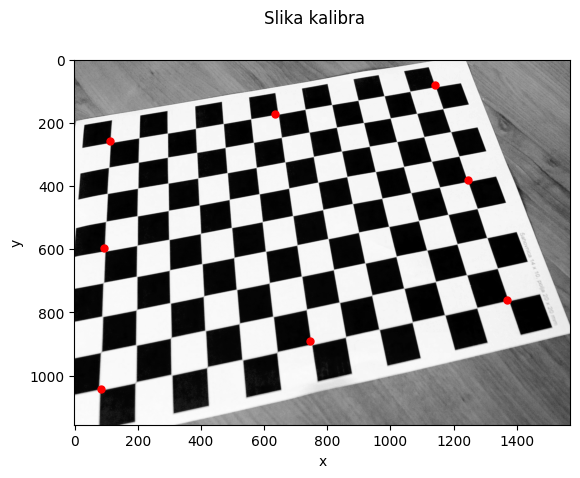

In [34]:
pts = np.array(points)
iCalImageG = colorToGray(iCalImage)
showImage( iCalImageG, 'Slika kalibra' )
plt.plot(pts[:,0], pts[:,1], 'or', markersize=5.0)        
# koordinate v prostoru slike
iCoorU = pts[:,0].flatten()
iCoorV = pts[:,1].flatten()
# koordinate kalibra v metricnem prostoru
iCoorX = np.array([20, 140, 260, 260, 260, 140,  20,  20])
iCoorY = np.array([20,  20,  20, 100, 180, 180, 180, 100])
# oblikuj koordinate v matrike (Nx2)
ptsUV = np.vstack( (iCoorU, iCoorV) ).transpose()
ptsXY = np.vstack( (iCoorX, iCoorY) ).transpose()
# doloci zacetni priblizek parametrov
oMatA = mapAffineApprox2D( ptsUV, ptsXY )
#    oMatA = rvlib.mapAffineApprox2D( ptsXY, ptsUV )
# preslikava identiteta
Uc = iCalImageG.shape[1]/2
Vc = iCalImageG.shape[0]/2
iParIdent = np.array([1,0,0,0,1,0,0,0,Uc,Vc,0])
# preslikava z afinim priblizkom
Uc = iCalImageG.shape[1]/2
Vc = iCalImageG.shape[0]/2
iParAffine = np.array([oMatA[0,0], oMatA[0,1], oMatA[0,2],\
                       oMatA[1,0], oMatA[1,1], oMatA[1,2],\
                       0, 0, Uc, Vc, 0])
# doloci napako z danimi parametri
oErr2ident = geomCalibErr( iParIdent, iCoorU, iCoorV, iCoorX, iCoorY )
oErr2affine = geomCalibErr( iParAffine, iCoorU, iCoorV, iCoorX, iCoorY )
print('ident err: ', oErr2ident)
print('affine err: ', oErr2affine)

In [35]:
print(np.array(-43, dtype='uint16'))

65493


C:\Users\gj1182\AppData\Local\Temp\ipykernel_5640\3898156973.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -43 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  print(np.array(-43, dtype='uint16'))


Iter   [a11 a12 tx a21 a22 ty px py uc vc k]   f(X)     
  20    4.825   0.632  -60.398  -0.924   4.507  188.501              6.777e-05  -2.099e-04   820.104   568.650  2.635e-04    2261.829291
  40    4.807   0.552  -57.354  -0.936   4.457  181.265              1.465e-04  -4.515e-04   783.781   659.664  5.378e-04    2019.578824
  60    4.817   0.548  -57.736  -0.879   4.441  184.525              1.744e-04  -4.478e-04   800.073   638.032  9.755e-04    1884.034936
  80    4.886   0.449  -60.411  -0.840   4.337  180.181              2.448e-04  -6.016e-04   837.768   620.167  1.532e-03    1535.668961
 100    5.040   0.294  -60.123  -0.759   4.156  186.035              3.975e-04  -7.852e-04   851.516   643.222  2.988e-03    1155.127317
 120    5.127   0.261  -58.813  -0.694   4.029  191.259              4.682e-04  -8.199e-04   867.410   609.311  4.016e-03    980.490443
 140    5.134   0.249  -58.121  -0.668   3.979  186.918              5.061e-04  -8.797e-04   819.216   631.755  4.555e-03 

C:\Users\gj1182\AppData\Local\Temp\ipykernel_5640\3619947157.py:19: RuntimeWarning: Maximum number of iterations has been exceeded.
  iParOpt = fmin(func=F, x0=iParAffine, maxiter=1000, disp=1, xtol=1e-6,


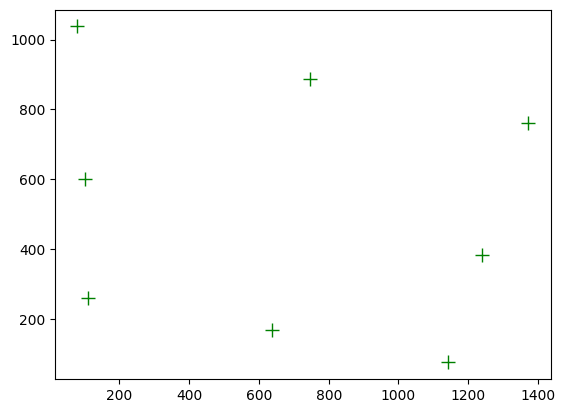

In [36]:
# nacrtaj funkcijo za izpisovanje vrednosti parametrov        
Nfeval = 1   
step = 50
def callbackF(Xi):
    global Nfeval
    if Nfeval % 20 == 0:
        np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
        formattedline = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f  \
            %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(Xi[:]) )
        print('{0:4d}   {1}   {2: 3.6f}'.format(Nfeval, formattedline, F(Xi)))
    Nfeval += 1

# uporabi simpleksno optimizacijo
Nfeval = 1
from scipy.optimize import fmin
F = lambda x: geomCalibErr( x, iCoorU, iCoorV, iCoorX, iCoorY )
print('{0:4s}   {1:20s}   {2:9s}'.format('Iter', 
      '[a11 a12 tx a21 a22 ty px py uc vc k]', 'f(X)'))
iParOpt = fmin(func=F, x0=iParAffine, maxiter=1000, disp=1, xtol=1e-6, 
               ftol=1e-6, callback=callbackF, maxfun=None )
formattedline1 = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f \
    %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(iParAffine[:]) )
formattedline2 = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f \
    %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(iParOpt[:]) )
print('zacetni parametri: ', formattedline1)
print('koncni parametri: ', formattedline2)     

iCoorUt, iCoorVt = geomCalibTrans( iParOpt, iCoorX, iCoorY )
plt.plot(iCoorUt, iCoorVt, '+g', markersize=10.0)

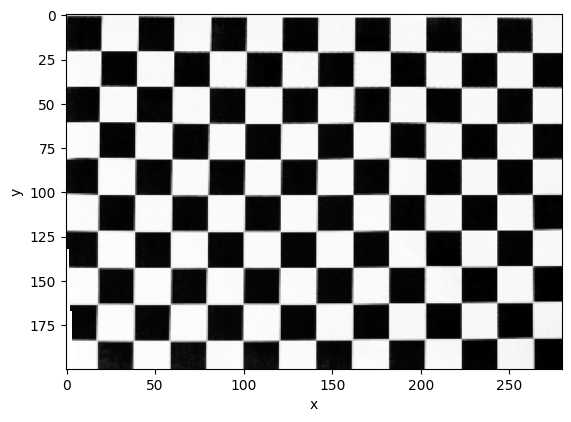

In [37]:
iCoorX, iCoorY = np.meshgrid(range(iCalImage.shape[1]),range(iCalImage.shape[0]),sparse=False, indexing='xy')
oCoorU, oCoorV = transProjective2D(iParOpt, iCoorX, iCoorY)
s = 1
dy, dx = iCalImageG.shape
oInterpImageG = interpn((np.arange(dy), np.arange(dx)), 
                        iCalImageG, 
                        (oCoorV, oCoorU), 
                        method = "linear", bounds_error=False)

showImage(oInterpImageG[0:200,0:280])


ValueError: maximum supported dimension for an ndarray is 32, found 1156

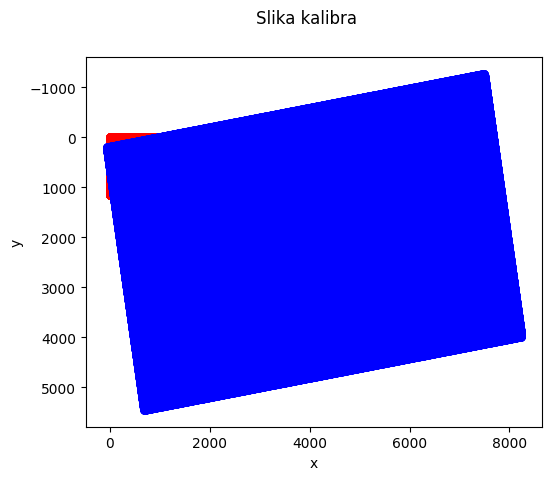

In [38]:
# prikazi tocke pred in po afini preslikavi
plt.close('all')
showImage( iCalImageG, 'Slika kalibra' )
plt.plot(iCoorU,iCoorV,'om',markersize=5.0)
iCoorUt, iCoorVt = geomCalibTrans( iParIdent, iCoorX, iCoorY )
plt.plot(iCoorUt,iCoorVt,'or',markersize=5.0)
iCoorUt, iCoorVt = geomCalibTrans( iParAffine, iCoorX, iCoorY )
plt.plot(iCoorUt,iCoorVt,'ob',markersize=5.0)


def interpolate0Image2D(iImage, iCoorX, iCoorY ):
    X, Y = iCoorX, iCoorY #X,Y sta matriki lokacij X elementov točk in Y elemetnov točk
    X[X<0]=0
    Y[Y<0]=0
    X[X<iImage.shape[1]-1]=iImage.shape[1]-1
    Y[Y<iImage.shape[0]-1]=iImage.shape[0]-1
    X = np.round(X).astype('uint16')
    Y = np.round(Y).astype('uint16')
    oImage = iImage[Y,X]
    return oImage

#tukaj je koda, da zdaj to oznaceno obmocje/tocke preslikamo cez celotno prikazno okno
iCoorX, iCoorY = np.meshgrid(range(iCalImage.shape[1]),range(iCalImage.shape[0]),sparse=False, indexing='xy')
oMat2D = mapAffineApprox2D(ptsUV,ptsXY)
points = [iCoorX.flatten(), iCoorY.flatten()]
points = np.array(points).T
points = np.hstack((points, np.ones((points.shape[0],1))))
points = np.dot(points, oMat2D.T)

iCoorU = points[:,0].reshape(iCoorX)
iCoorV = points[:,1].reshape(iCoorY)
oImage = interpolate0Image2D(iCalImageG, iCoorU, iCoorV)
showImage(oImage)